In [1]:
# Imports
import importlib
from collections import Counter
import src.data.CMU_dataset_dataloader as CMU_dataset_dataloader
import src.utils.data_utils as data_utils
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf

importlib.reload(CMU_dataset_dataloader)
importlib.reload(data_utils)

# Constants
CMU_DATA_DOWNLOAD_PATH = 'https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'
CMU_DATA_PATH_INITIAL = 'data/initial/'
CMU_DATA_PREPROCESSED_PATH = 'data/preprocessed/'

sns.set_palette("colorblind") 
sns.set_style("whitegrid")

In [2]:
# Load the movie metadata
print("\nLoading Movie Metadata...")


categories = [
    'wikipedia_movie_id',
    'freebase_movie_id',
    'movie_name',
    'release_date',
    'box_office_revenue',
    'runtime',
    'languages',
    'countries',
    'genres'
]

movies = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'movie.metadata.tsv', categories=categories)
df_movies = movies.data

print("\nSample of Movie Metadata:")
display(df_movies.sample(5))

print("\nData Summary:")
print(df_movies.info())

missing_values = df_movies.isnull().sum()
print("\nMissing Values by Column:")
print(missing_values[missing_values > 0])


Loading Movie Metadata...

Sample of Movie Metadata:


,wikipedia_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
434,20484431,/m/04zy_fy,City Out of Wilderness,1974,NaN,28.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/0jtdp"": ""Docum..."
48213,2969022,/m/08gsgr,The Killer Elite,1975-12-19,NaN,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0cq22f9"": ""Actio..."
17102,4891644,/m/0csw88,Chamber of Horrors,1966,NaN,99.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03npn"": ""Horror"", ""/m/01585b"": ""Slasher""}"
40759,15899367,/m/03qfbry,Filming Othello,1978,NaN,84.0,"{""/m/02h40lc"": ""English Language""}","{""/m/082fr"": ""West Germany""}","{""/m/0jtdp"": ""Documentary""}"
74509,19946592,/m/03mhjb1,Kajraare,2009-02-13,NaN,NaN,"{""/m/03k50"": ""Hindi Language"", ""/m/02hxcvy"": ""...","{""/m/03rk0"": ""India"", ""/m/05sb1"": ""Pakistan""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th..."



Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   wikipedia_movie_id  81741 non-null  int64  
 1   freebase_movie_id   81741 non-null  object 
 2   movie_name          81741 non-null  object 
 3   release_date        74839 non-null  object 
 4   box_office_revenue  8401 non-null   float64
 5   runtime             61291 non-null  float64
 6   languages           81741 non-null  object 
 7   countries           81741 non-null  object 
 8   genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB
None

Missing Values by Column:
release_date           6902
box_office_revenue    73340
runtime               20450
dtype: int64


In [3]:
df_movies = df_movies.copy()

# Removing freebase (deprecated)
if 'freebase_movie_id' in df_movies.columns:
    df_movies.drop(columns=['freebase_movie_id'], inplace=True)

df_movies = df_movies.dropna(subset=['box_office_revenue'])

assert df_movies['box_office_revenue'].isnull().sum() == 0

df_movies['languages'] = df_movies['languages'].apply(data_utils.convert_to_dict)
df_movies['countries'] = df_movies['countries'].apply(data_utils.convert_to_dict)

In [4]:
print("Loading Plot Summaries...")

# Specify only the necessary columns for loading
categories = ['movie_id', 'summary']

# Load data
plots = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'plot_summaries.txt', categories=categories)
df_plots = plots.data

print("\nSample of Plot Summaries:")
display(df_plots.sample(5))

print("\nPlot Summaries Data Summary:")
print(df_plots.info())

# Check for missing values in 'summary' column
missing_values = df_plots['summary'].isnull().sum()
if missing_values > 0:
    print(f"\nWarning: There are {missing_values} missing values in the 'summary' column.")
else:
    print("\nNo missing values in the 'summary' column.")

Loading Plot Summaries...

Sample of Plot Summaries:


,movie_id,summary
23771,21141408,"Talented musician Vishal Krishnamoorthy , retu..."
61,3459677,"Raj Mittal , Veer Saxena and Aryan Kapoor ar..."
39652,33534917,Against the backdrop of metropolitan Seoul's f...
22711,7005141,Charlie Y. Reader is a 35-year-old theatrical...
2136,9424571,The film portrays the lives of the members of ...



Plot Summaries Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  42303 non-null  int64 
 1   summary   42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB
None

No missing values in the 'summary' column.


count    42303.000000
mean      1784.034300
std       1808.925641
min         99.000000
25%        508.000000
50%       1079.000000
75%       2604.500000
max      28159.000000
Name: summary_length, dtype: float64


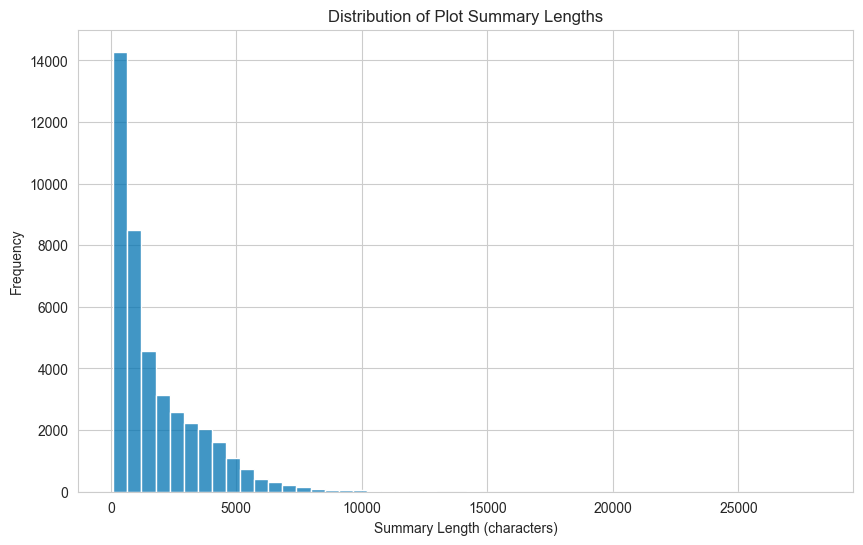

,movie_id,summary,summary_length
28920,10640559,Arrested for a wide variety of infringements o...,1307
24591,5638171,A guide and a tourist are birdwatching in the ...,1750
11659,27617747,The Secret Agent Matt Considine accepts a dan...,328
29857,735291,"{{Plot|dateCast""wikitable"" !Actor !Role |- |Ed...",500
27528,11980800,"McMurphy comes to Denver, Colorado to see Pol...",1671


In [5]:
assert df_plots['summary'].isnull().sum() == 0, "Missing values found in 'summary' column"
assert df_plots['movie_id'].isnull().sum() == 0, "Missing values found in 'movie_id' column"

# Average plot summary length
df_plots['summary_length'] = df_plots['summary'].apply(len)
print(df_plots['summary_length'].describe())

df_plots.to_csv(CMU_DATA_PREPROCESSED_PATH + 'plot_summaries.csv', index=False)

# summary lengths distribution
plt.figure(figsize=(10,6))
sns.histplot(df_plots['summary_length'], bins=50)
plt.title('Distribution of Plot Summary Lengths')
plt.xlabel('Summary Length (characters)')
plt.ylabel('Frequency')
plt.show()

df_plots.sample(5)

In [6]:
# Sentiment Analysis
#Vader
#%pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
analyzer = SentimentIntensityAnalyzer()
df_plots['vader_scores'] = df_plots['summary'].apply(lambda x: analyzer.polarity_scores(x))

df_plots.head(5)

In [20]:
%pip install textblob
from textblob import TextBlob

df_plots.sample(20)
# Function to get TextBlob sentiment
def get_textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment

# Apply TextBlob sentiment analysis
df_plots['textblob_sentiment'] = df_plots['summary'].apply(get_textblob_sentiment)

df_plots.head(5)

,movie_id,summary,summary_length,vader_scores,textblob_sentiment
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"{'neg': 0.083, 'neu': 0.832, 'pos': 0.084, 'co...","(0.2, 0.6)"
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"{'neg': 0.132, 'neu': 0.791, 'pos': 0.077, 'co...","(0.0452610693400167, 0.4072451963241437)"
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"{'neg': 0.178, 'neu': 0.704, 'pos': 0.119, 'co...","(0.04954954954954956, 0.3684684684684684)"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"{'neg': 0.111, 'neu': 0.786, 'pos': 0.103, 'co...","(0.03054998514557338, 0.47620692216280447)"
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"{'neg': 0.108, 'neu': 0.825, 'pos': 0.067, 'co...","(0.06391293891293891, 0.4222582972582973)"


In [23]:
merged_df = df_plots.merge(df_movies, left_on='movie_id', right_on='wikipedia_movie_id', how='inner')

merged_df = merged_df.drop(columns=['wikipedia_movie_id', 'release_date', 'runtime', 'languages', 'countries', 'genres'])
merged_df.sample(5)

,movie_id,summary,summary_length,vader_scores,textblob_sentiment,movie_name,box_office_revenue
1753,33388421,The film starts with a dream sequence depictin...,5216,"{'neg': 0.083, 'neu': 0.879, 'pos': 0.038, 'co...","(0.051333715304303536, 0.36115673542144133)",11-11-11,5232771.0
2632,7715229,This film begins with the last game of the Ame...,3478,"{'neg': 0.075, 'neu': 0.837, 'pos': 0.088, 'co...","(0.04303675048355899, 0.40950999355254675)",The Game Plan,150000000.0
2039,893808,The film opens in a world of anthropomorphic r...,4644,"{'neg': 0.084, 'neu': 0.839, 'pos': 0.077, 'co...","(0.07793175659029318, 0.5065656565656566)",Robots,260718330.0
795,8538374,"Presented as a flashback, The Last Mimzy is th...",3625,"{'neg': 0.06, 'neu': 0.849, 'pos': 0.092, 'com...","(0.1103771542922486, 0.4359146042636608)",The Last Mimzy,27297450.0
5480,2973132,The Namesake depicts the struggles of Ashoke a...,2678,"{'neg': 0.065, 'neu': 0.846, 'pos': 0.089, 'co...","(0.17379679144385027, 0.431283422459893)",The Namesake,20138836.0


In [36]:
merged_df.sort_values(by='box_office_revenue', ascending=False, inplace=True)
# Divide movies into 4 groups based on box office revenue
merged_df['box_office_group'] = pd.qcut(merged_df['box_office_revenue'], 4, labels=['Low', 'Medium', 'High', 'Very High'])
merged_df.head(5)


,movie_id,summary,summary_length,vader_scores,textblob_sentiment,movie_name,box_office_revenue,box_office_group
5509,4273140,"By 2154, humans have severely depleted Earth'...",2928,"{'neg': 0.153, 'neu': 0.747, 'pos': 0.1, 'comp...","(-0.032613636363636365, 0.4267045454545454)",Avatar,2.782275e+09,Very High
5083,52371,"In 1996, treasure hunter Brock Lovett and his...",5079,"{'neg': 0.104, 'neu': 0.786, 'pos': 0.11, 'com...","(0.279803550207962, 0.6566436423054071)",Titanic,2.185372e+09,Very High
6746,22114132,"The Asgardian Loki encounters the Other, the ...",4154,"{'neg': 0.094, 'neu': 0.858, 'pos': 0.048, 'co...","(-0.04942067736185382, 0.44446142093200913)",The Avengers,1.511758e+09,Very High
7517,31941988,{{further2}} {{See also}} As Lord Voldemort r...,4402,"{'neg': 0.228, 'neu': 0.713, 'pos': 0.059, 'co...","(0.07083333333333333, 0.4470238095238095)",Harry Potter and the Deathly Hallows – Part 2,1.328111e+09,Very High
874,25001260,"In 1961, the Ark, a Cybertronian spacecraft c...",4468,"{'neg': 0.132, 'neu': 0.81, 'pos': 0.058, 'com...","(-0.07510822510822514, 0.4051948051948053)",Transformers: Dark of the Moon,1.123747e+09,Very High


# Sentimental analysis

## Analysis Sentiment scores

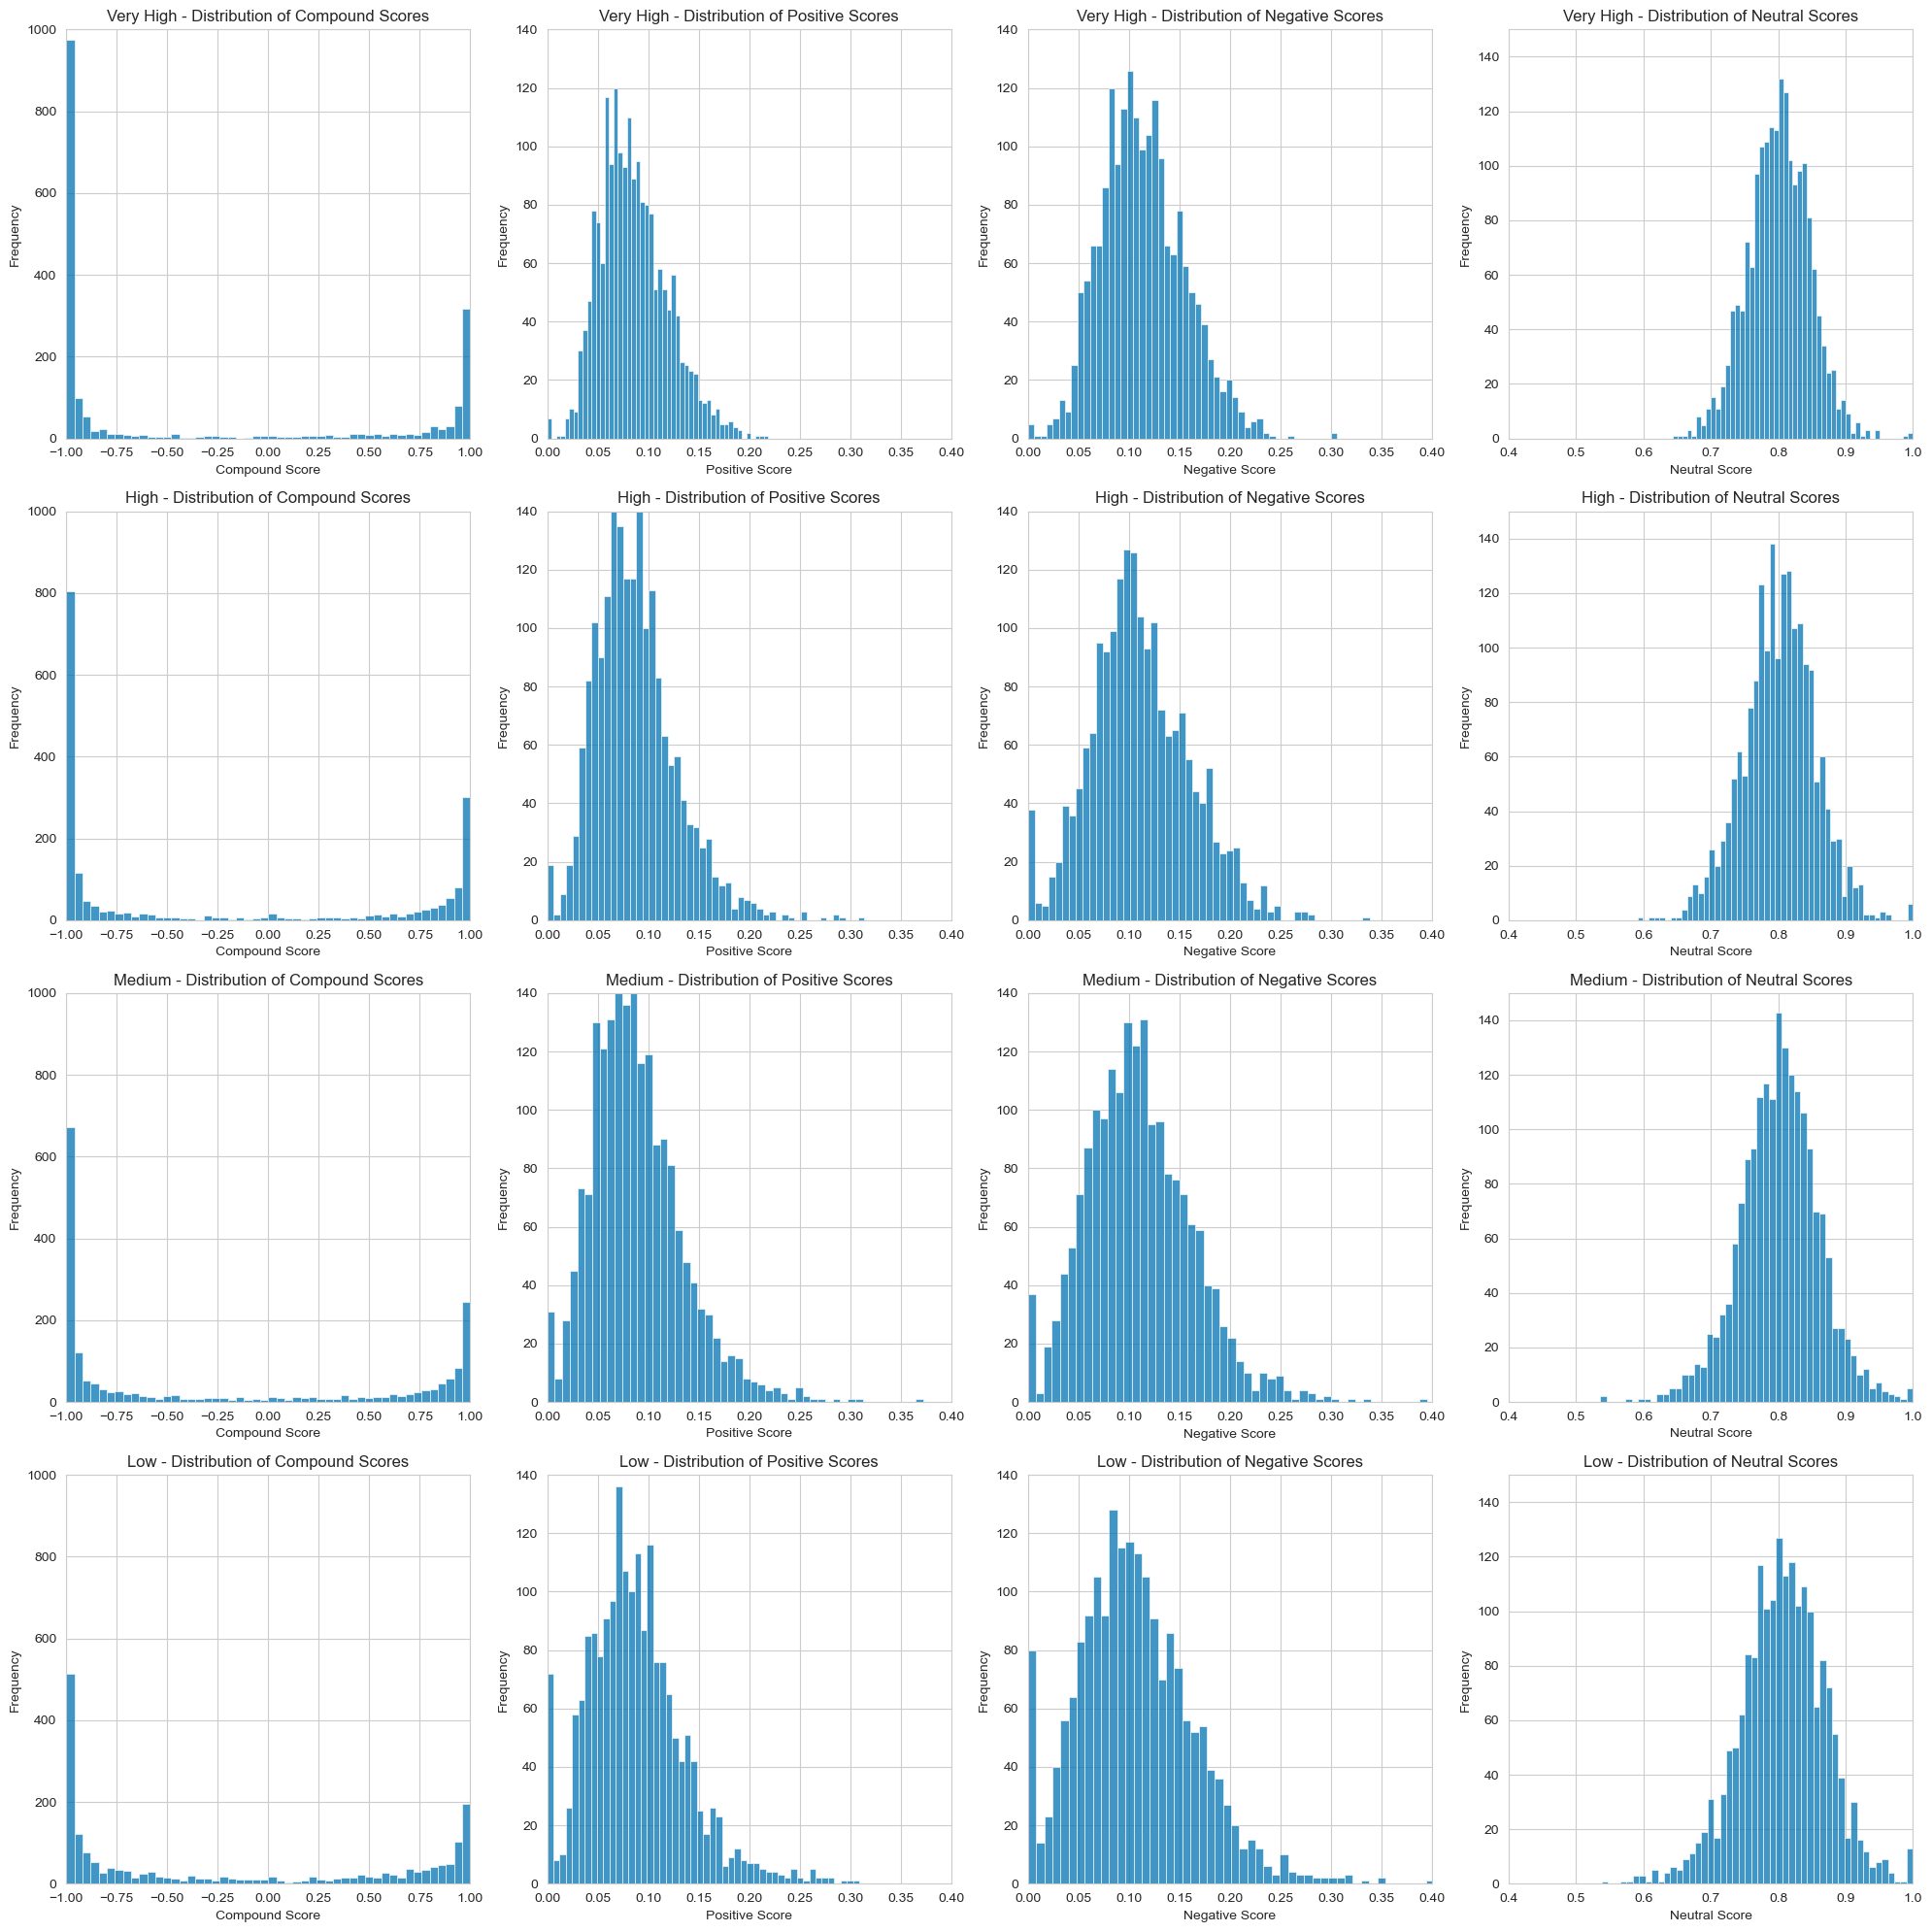

In [46]:
# Plotting distributions for each box office group
box_office_groups = merged_df['box_office_group'].unique()

fig, axs = plt.subplots(len(box_office_groups), 4, figsize=(20, 20))

for i, group in enumerate(box_office_groups):
    group_data = merged_df[merged_df['box_office_group'] == group]
    
    sns.histplot(group_data['vader_scores'].apply(lambda x: x['compound']), bins=50, ax=axs[i, 0])
    axs[i, 0].set_title(f'{group} - Distribution of Compound Scores')
    axs[i, 0].set_xlabel('Compound Score')
    axs[i, 0].set_ylabel('Frequency')

    sns.histplot(group_data['vader_scores'].apply(lambda x: x['pos']), bins=50, ax=axs[i, 1])
    axs[i, 1].set_title(f'{group} - Distribution of Positive Scores')
    axs[i, 1].set_xlabel('Positive Score')
    axs[i, 1].set_ylabel('Frequency')

    sns.histplot(group_data['vader_scores'].apply(lambda x: x['neg']), bins=50, ax=axs[i, 2])
    axs[i, 2].set_title(f'{group} - Distribution of Negative Scores')
    axs[i, 2].set_xlabel('Negative Score')
    axs[i, 2].set_ylabel('Frequency')

    sns.histplot(group_data['vader_scores'].apply(lambda x: x['neu']), bins=50, ax=axs[i, 3])
    axs[i, 3].set_title(f'{group} - Distribution of Neutral Scores')
    axs[i, 3].set_xlabel('Neutral Score')
    axs[i, 3].set_ylabel('Frequency')

    axs[i, 0].set_xlim(-1, 1)
    axs[i, 1].set_xlim(0, 0.4)
    axs[i, 2].set_xlim(0, 0.4)
    axs[i, 3].set_xlim(0.4, 1)
    axs[i, 0].set_ylim(0, 1000)
    axs[i, 1].set_ylim(0, 140)
    axs[i, 2].set_ylim(0, 140)
    axs[i, 3].set_ylim(0, 150)

plt.tight_layout()

- Pretty similar in the overall -> cannot say much about it
- Can still be interesting to put in the story, saying that it does not impact much the outcome.
- Small difference BUT : it seems that films with high revenue tends to have a less spread distribution

## Analysis Senitivity and Polarity scores

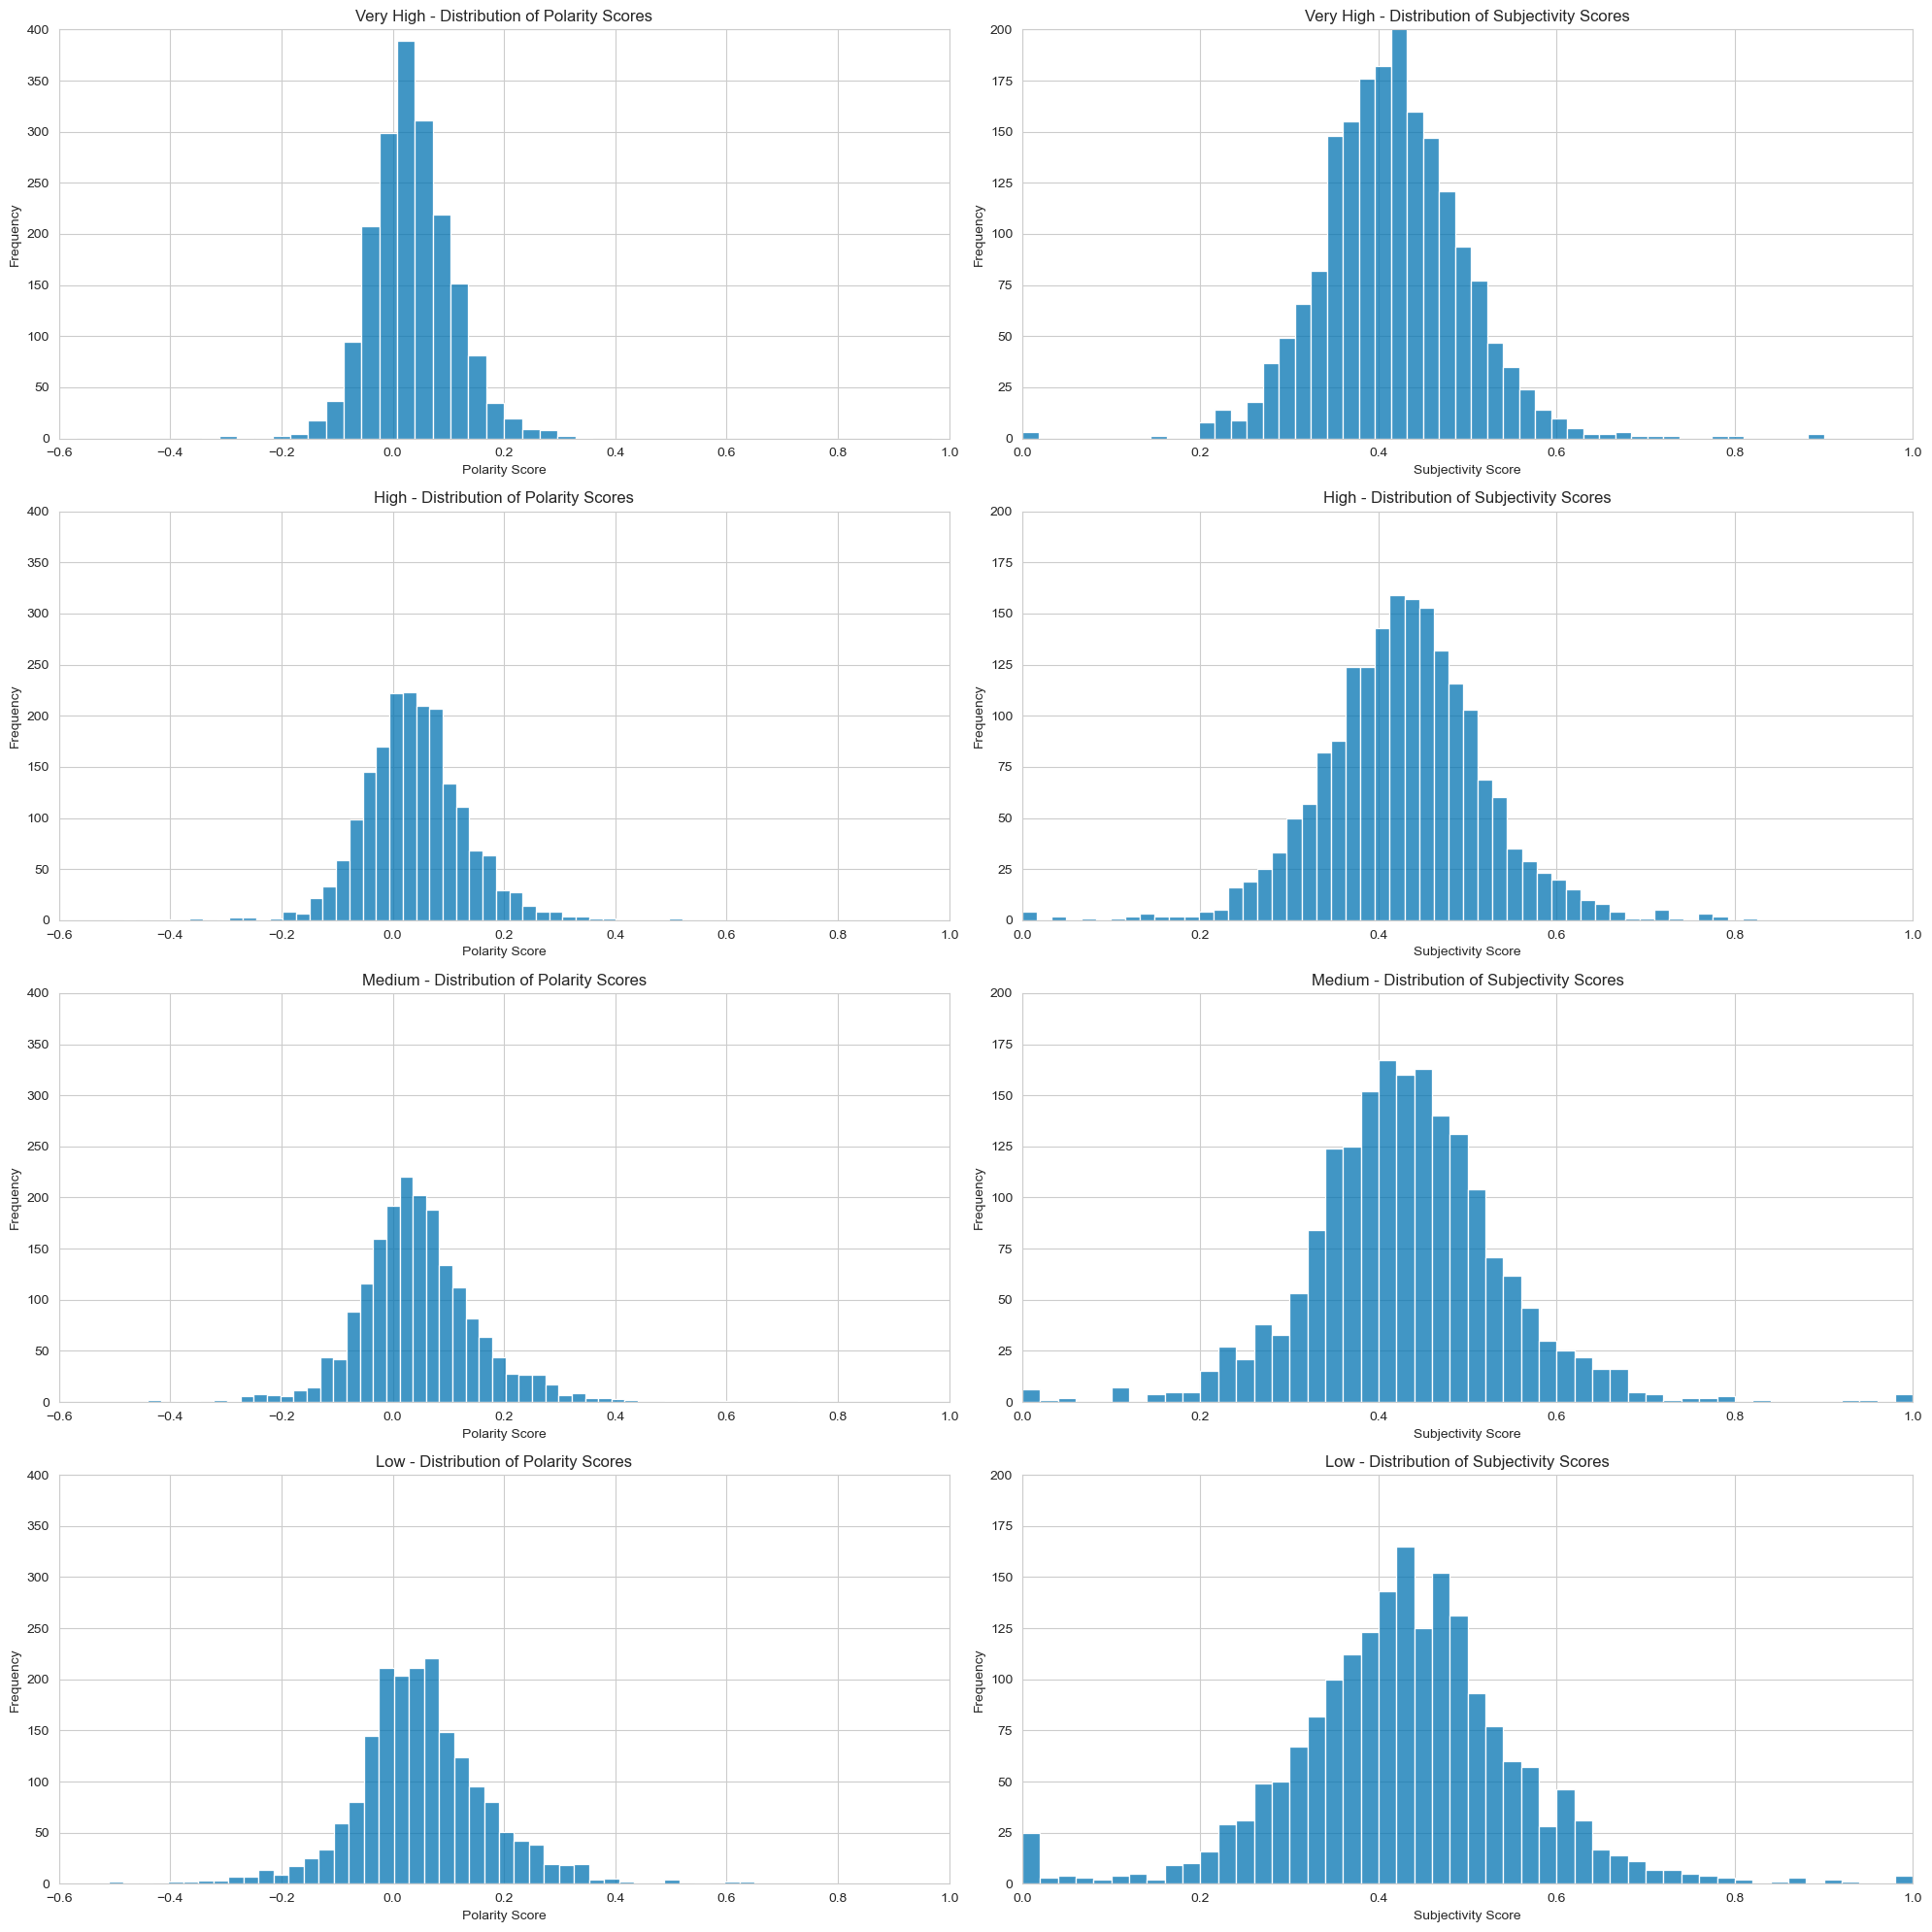

In [47]:
# Plotting distributions for each box office group
box_office_groups = merged_df['box_office_group'].unique()

fig, axs = plt.subplots(len(box_office_groups), 2, figsize=(20, 20))

for i, group in enumerate(box_office_groups):
    group_data = merged_df[merged_df['box_office_group'] == group]
    
    sns.histplot(group_data['textblob_sentiment'].apply(lambda x: x[0]), bins=50, ax=axs[i, 0])
    axs[i, 0].set_title(f'{group} - Distribution of Polarity Scores')
    axs[i, 0].set_xlabel('Polarity Score')
    axs[i, 0].set_ylabel('Frequency')

    sns.histplot(group_data['textblob_sentiment'].apply(lambda x: x[1]), bins=50, ax=axs[i, 1])
    axs[i, 1].set_title(f'{group} - Distribution of Subjectivity Scores')
    axs[i, 1].set_xlabel('Subjectivity Score')
    axs[i, 1].set_ylabel('Frequency')

    axs[i, 0].set_xlim(-0.6, 1)
    axs[i, 1].set_xlim(0, 1)
    axs[i, 0].set_ylim(0, 400)
    axs[i, 1].set_ylim(0, 200)

plt.tight_layout()

Nearly the same analysis as above.